# Connected and Autonomous Driving - Control module

----

In this module, we will learn how to control an autonomous vehicle to follow a specific path defined by a serie of waypoints. Our goal is to emulate the input command that would normally be provided by a human user: torque, brake and steering.

In this notebook, you will get to implement the PID controller covered in class, then use your code directly inside the CARLA Simulation.

## Introduction to scientific computing in Python

The practical sessions of this class assume some basic familiarity with Python, Jupyter Notebooks, and the NumPy ecosystem.

For an excellent introduction to these concepts, see [the following introductory notebook from Stanford University](https://drive.google.com/file/d/1iQ6yZ3R_SaMCbAUUkwarOk-iFPywQ4-7/view?usp=sharing).

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

## Longitudinal controller

Before handling directions, let's start by making our car follow a target speed by going in a straigth line.

### Let's start with a simple P controller

The Proportional (P) controller try to reduce the difference between the target speed and the current speed: $error(t) = v(t) - v_{target}$.

To do so, it provide a throttle value that is proportional to that error, with a factor called proportional gain $K_p$:

$$throttle = K_p * error(t)$$

Fill the code below in update() to calculate the error value as well as the output throttle

In [2]:
 
# Define PID Controller class with resistance
class ProportionalControllerWithResistance:
    def __init__(self, Kp, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.target_speed = target_speed
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        ##TODO##
        # error
        error = self.target_speed - current_value
        # output based on proportional error
        output = self.Kp * error
        # adjust the output for resistance
        throttle = output - self.resistance_factor * current_value
        ##TODO##
        return throttle #output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 


Now, let's do a simple simulation over 50 seconds to see how your controller behave
#### - Does it reach the target speed ?

No, the speed does not exactly reach the target of 50 m/s. The curve shows that the speed stabilises slightly below 50 m/s, probably because of the resistance. The controller tries to reduce the error, but the resistance (set at 0.2) creates a constant loss which prevents the target speed from being reached precisely.

For the second speed target (30 m/s), yes the speed almost reaches the 30 m/s target, but similarly it stabilises just below the target value. Once again, resistance plays a role in this discrepancy.

#### - What happens when you change $K_p$ ? The resistance ?

##### (a) Change of Kp

We can see that if we reduce Kp, convergence is even slower, because the throttle is less responsive to error. (This is problematic if you need quick adjustments).

If Kp is increased, the controller is more aggressive, and reaches the target more quickly. But too high a value can introduce oscillations or instability.

So a lower Kp makes the system too slow, which is not efficient.
A higher Kp makes the system faster, but there is a potential risk of oscillations or instability if Kp is too high.

So the optimum choice depends on the application and the trade-off between speed and stability.

##### (b) Change of the resistance

With a low resistance, the vehicle reaches a speed closer to the target, because the resistance does not have a significant impact in preventing me from approaching the target. 
But with high resistance, the vehicle reaches a speed significantly lower than the target, because the resistance becomes a greater constraint, reducing the controller's ability to compensate for the opposing forces.

Furthermore, we know that the resistance in the system models forces such as friction, air, or other losses (climbing a hill, for example) and directly influences the performance of the proportional controller.
If the resistance is too high, the speed will inevitably be too low (the vehicle will not be able to move forward) and the Kp gain will have to be adjusted. If the resistance is too low, then the vehicle may oscillate but reach the target speed more easily (straight line without obstacles).

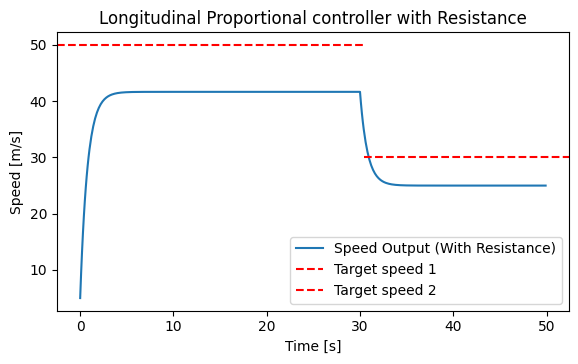

In [3]:
# Simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 50, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 30  # Time to change vehicle target speed
 
# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = ProportionalControllerWithResistance(Kp=1, target_speed=target_speed1, resistance_factor=0.2)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)
 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Speed Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Target speed 1', xmax=switch_t/50)
plt.axhline(target_speed2, color='r', linestyle='--', label='Target speed 2', xmin=switch_t/50)
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Longitudinal Proportional controller with Resistance')
plt.legend()
plt.show()

### Result with default value (Kp=1 & resistance_factor = 0.2)

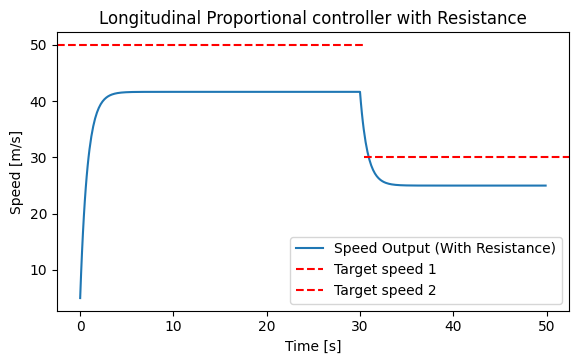


As you can see, the speed gradually increases from 0 m/s to reach the first target (50 m/s).

The controller seems to converge towards the target with a slight difference caused by resistance.

After 30 seconds (the moment of change), the speed starts to decrease to reach the new target (30 m/s).
The system adjusts quickly with no major oscillations. Here again, there is a difference caused by resistance.



### Result with value Kp = 0.1 & resistance_factor = 0.2 (see the influence of Kp) part. 1/2

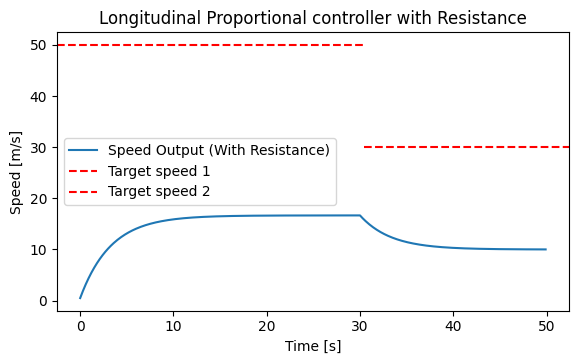


### Result with value Kp = 2 & resistance_factor = 0.2 (see the influence of Kp) part. 2/2

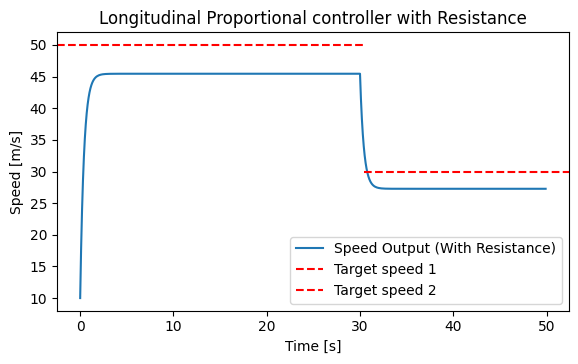


### Result with Kp = 1 (default value) & resistance_factor = 0.1 (see the influence of resistance_factor) part. 1/2

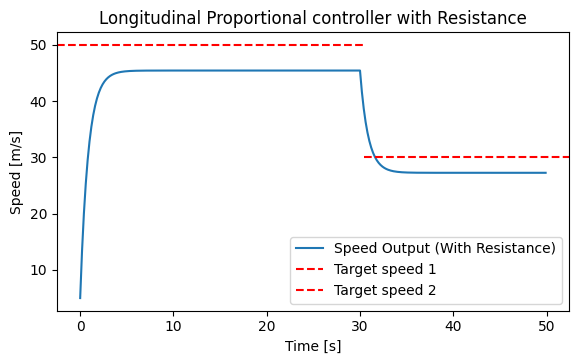

### Result with Kp = 1 (default value) & resistance_factor = 0.3 (see the influence of resistance_factor) part. 2/2

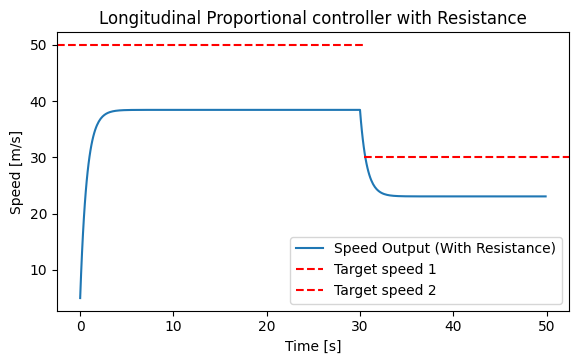

### Note for Maxence & Ali
#### What is the purpose of ‘resistance’?

Resistance reflects the real conditions that a vehicle encounters in a practical environment!

In the real world, a vehicle has to overcome several forces that oppose its movement, such as : 
- Air resistance (proportional to the square of the speed).
- Ground friction or rolling resistance.
- Slope or gravity if the vehicle is climbing a hill.

Resistance is a simplification of these forces, enabling the robustness of the controller to be tested against realistic constraints.

### Adding integrals to look at the past

To get closer to the target, we improve our controler as a proportional integral (PI). 

$$throttle(t) = K_p * error(t) + K_i * \sum_{n=0} ^t error(n)\Delta t $$

The additional term accumulate previous errors over time to close the gap with the target.

Include this new version in the update() method.

### Note for Maxence & Ali
#### Why add an integral component?

In the P controller we used earlier, there can still be a steady-state error between the actual speed and the target speed due to factors such as resistance.

The integral component ‘looks into the past’ to correct this discrepancy by accumulating errors over time and increasing the throttle command accordingly.


Note: 
Adding the integral can cause oscillations or instability if the integral gain Ki is too high. A good choice of parameters Kp and Ki is essential to ensure fast and stable convergence.

In [14]:
class PIControllerWithResistance:
    def __init__(self, Kp, Ki, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.target_speed = target_speed
        self.integral = 0
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        ##TODO##
        # error
        error = self.target_speed - current_value
        
        # update integral term
        self.integral += error * dt # Sum of (error * time step)
        
        # output (P+I control)
        output = self.Kp * error + self.Ki * self.integral
        
        # apply resistance to recude the throttle
        ##TODO##
        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 

Let's simulate again.

##### - Is it reaching the target better than before ?

Yes, the PI controller achieves a target speed more precisely than a simple proportional controller. The integral term compensates for the steady-state error by accumulating past errors. This reduces the gap between the speed achieved and the target speed.

##### - Why did the integral component improve the controller ?

The integral term accumulates past errors over time, helping to correct for constant deviations between the speed achieved and the target speed. By integrating these errors, the controller is able to reduce the effect of resistance or other constant disturbances that prevent the system from reaching the target exactly.

##### - What new issue did the PI introduce ?

The main problem introduced by the PI controller is the ‘integral wind-up’.
This phenomenon occurs when the error accumulates excessively, for example when the system gets stuck or overshoots the target. This can lead to significant oscillation or overshoot before stabilising at the target value. In our graph, we can see a slight overshoot before the system stabilises.


##### - what happens when you change $K_p$ and $K_i$ ?

##### (a) Kp

As Kp decreases, the controller becomes less responsive and the curve takes longer to reach the target speed. In fact, convergence is slower, and the controller's ability to follow speed changes is reduced.
So a low Kp leads to more stable but slower behaviour.

When Kp increases the controller becomes more aggressive, and reaches the target speed more quickly. However, this aggressiveness can introduce a slight initial overcompensation (overshoot), where the speed temporarily exceeds the target vvalue before stabilising. This can lead to oscillations in extreme cases if Kp is too high.

##### (b) Ki

As Ki decreases, the impact of the integral becomes less significant. The controller is less good at compensating for accumulated errors, which can leave a slight residual gap between the speed achieved and the target speed.
This can slow down the correction of small persistent errors due to resistance.

As Ki increases, the controller compensates for accumulated errors more quickly, reducing any residual deviation.
However, too high a value of Ki can lead to oscillations, as the integral can OVERcorrect the errors.
This can be seen in our graph, where the speed oscillates slightly before stabilising


##### Conclusion

Kp controls the speed and responsiveness of the response. It directly adjusts the intensity of the correction according to the instantaneous error.

Ki eliminates errors accumulated over the long term, but can introduce oscillations if its value is too high.

Finding the right values for Kp and Ki is a question of balancing stability, speed and precision.

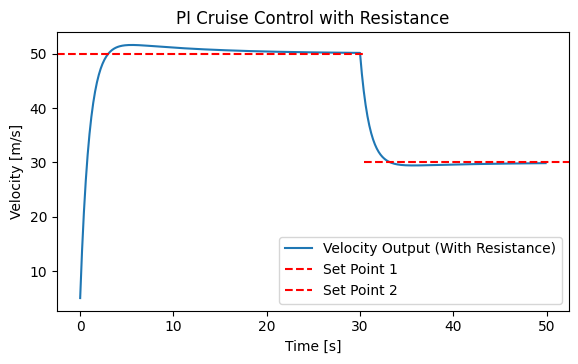

In [5]:
# Simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 50, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 30  # Time to change vehicle target speed
 
# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = PIControllerWithResistance(Kp=1.0, Ki=0.1, target_speed=target_speed1, resistance_factor=0.05)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)
 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Velocity Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Set Point 1', xmax=switch_t/50)
plt.axhline(target_speed2, color='r', linestyle='--', label='Set Point 2', xmin=switch_t/50)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('PI Cruise Control with Resistance')
plt.legend()
plt.show()

#### Result with default value (Kp = 1.0 & Ki = 0.1)

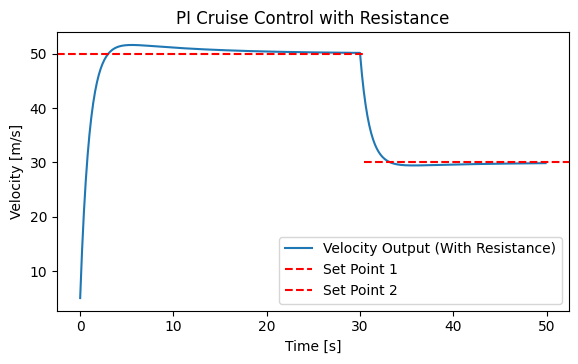

#### Result with Kp = 0.5 & Ki = 0.1 (default value) (see the influence of Kp) part. 1/2

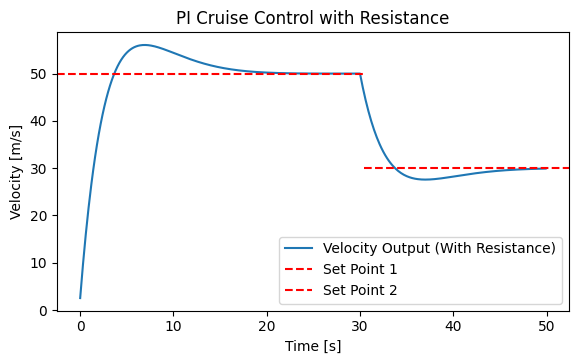

#### Result with Kp = 1.5 & Ki = 0.1 (default value) (see the influence of Kp) part. 2/2

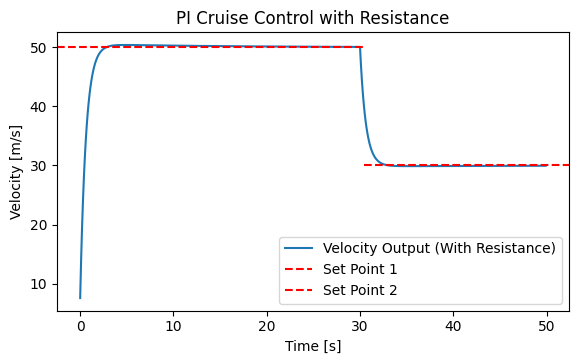

#### Result with Kp = 1.0 (default value) & Ki = 0.05 (see the influence of Ki) part. 1/2

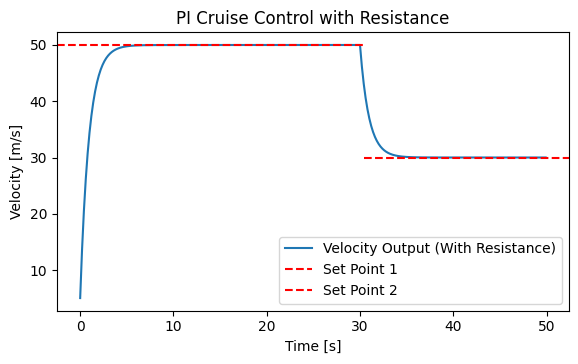

#### Result with Kp = 1.0 (default value) & Ki = 0.15 (see the influence of Ki) part. 2/2

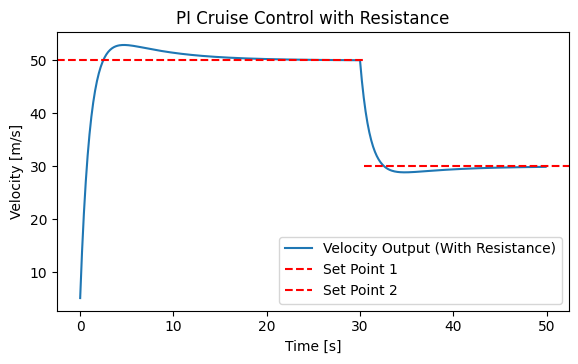

### Finishing the PID

Finally, the Proportional Integral Derivative (PID) controller adds a term to consider future error:

$$throttle(t) = K_p * error(t) + K_i * \sum_{n=0} ^t error(n)\Delta t + K_d * \frac{error(t)-error(t-1)}{\Delta t} $$

### Notes by Maxence

#### Why add a derivative term?

The derivative component we've just added to our formula allows us to predict future errors by evaluating the speed at which the error changes (its derivative). This reduces oscillations and improves system stability.

##### Anticipation of future errors: 

The derivative term acts like a forecast. If the error changes rapidly, the controller adjusts the command accordingly to avoid oscillations or excessive overshoots.

##### Oscillation reduction:

If the PI controller causes oscillations around the target (as we have seen in some graphs), the derived term slows the response when it detects a rapid change, stabilising the system.

##### Increased stability: 

The derived term compensates for the limitations of the PI controller by taking into account the dynamics of the system.

In [20]:
class PIDControllerWithResistance:
    def __init__(self, Kp, Ki, Kd, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.target_speed = target_speed
        self.prev_error = 0
        self.integral = 0
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        ##TODO##
        # error
        error = self.target_speed - current_value
        
        # integral (sum of past errors)
        self.integral += error * dt
        
        # derivative (change of the error)
        derivative = (error - self.prev_error) / dt
        
        # PID : sum of proportional contribution integral & derivative
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        
        # update the previous error for the next iteration
        self.prev_error = error
        ##TODO##
        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 

Let s simulate again

#### - Is it reaching the target better than before ?

Yes, the PID controller achieves the target speed more precisely than the PI controller or the P controller alone.
The derivative term helps to minimise oscillations and achieve stabilisation around the target speed more quickly.

#### - Why did the derivative component improve the controller ? 

The derived component (Kd) improves the controller by anticipating changes in the error:
- Main role: It mitigates oscillations around the target by responding to rapid changes in the error.
- Stability: It acts as a brake on sudden error growth, reducing overshoot.
- Prediction: The derivative term predicts the immediate future by analysing the variation in the error, which helps to adjust the control before the error becomes too large.

Basically, the system becomes more stable and reaches the target with fewer oscillations or overshoots.

#### - what happens when you change $K_p$, $K_i$ and $K_d$ ?

##### (a) Kp

Increasing Kp: Makes the system more responsive and enables the target speed to be reached more quickly. However, this can introduce oscillations if Kp is too high. But here, the increase has not been problematic thanks to the terms Ki and Kd. This means that they allow the value of Kp to be increased a little more, so that the target speed can be reached more quickly, without causing problems. 

Decreasing Kp: slows down the system's response. So the controller is less responsive, and the speed reaches the target more slowly.

##### (b) Ki

Ki increase: Improves the suppression of persistent errors, but if Ki is too high, this can cause oscillations or instabilities.

Decreasing Ki: Reduces the system's ability to correct steady-state errors. This slightly slows convergence to the target speed after setpoint changes.

##### (c) Kd

Increasing Kd: Helps to dampen oscillations and makes the response more stable, particularly during setpoint transitions.

Decreasing Kd: Reduces the controller's ability to anticipate rapid changes, which can lead to oscillations after a setpoint change.

##### Conclusion 

Kp determines overall responsiveness, Ki manages long-term errors and Kd helps stabilise the system.
Adding Kd makes the system more robust to oscillations and improves the accuracy of the dynamic response.

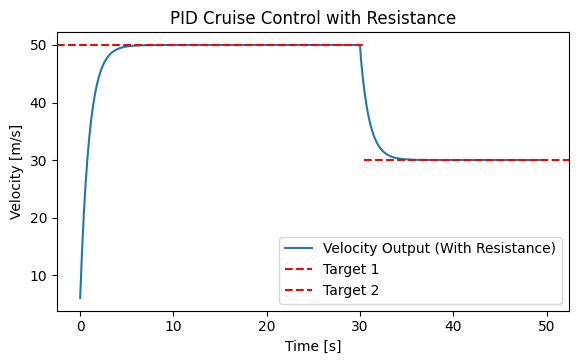

In [15]:
# Simulation parameters
dt = 0.1  # Time step
time = np.arange(0, 50, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 30  # Time to change vehicle target speed

# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = PIDControllerWithResistance(Kp=1.0, Ki=0.05, Kd=0.02, target_speed=target_speed1, resistance_factor=0.05)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)

 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Velocity Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Target 1', xmax=switch_t/50)
plt.axhline(target_speed2, color='r', linestyle='--', label='Target 2', xmin=switch_t/50)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('PID Cruise Control with Resistance')
plt.legend()
plt.show()

#### Result for defaults values (Kp = 1.0, Ki = 0.05 & Kd = 0.01)

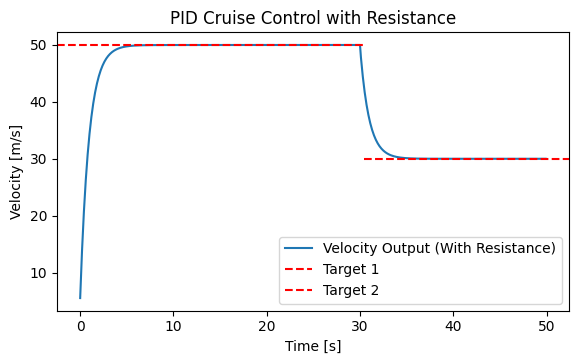

#### Result for Kp = 0.5, Ki = 0.05 & Kd = 0.01 (see the influence of Kp) part. 1/2

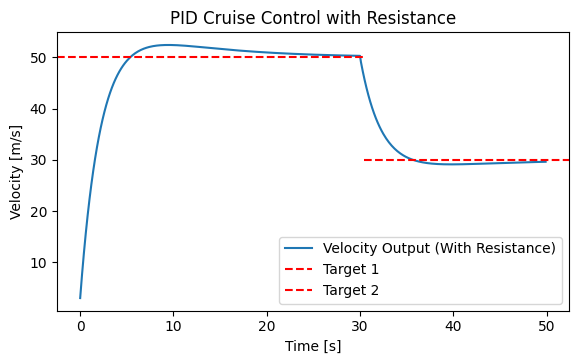

#### Result for Kp = 1.5, Ki = 0.05 & Kd = 0.01 (see the influence of Kp) part. 2/2

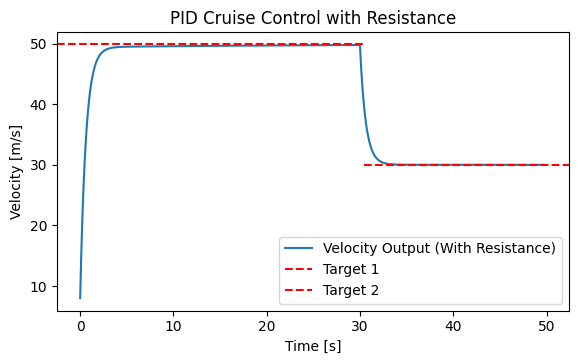

#### Result for Kp = 1.0, Ki = 0.025 & Kd = 0.01 (see the influence of Ki) part. 1/2

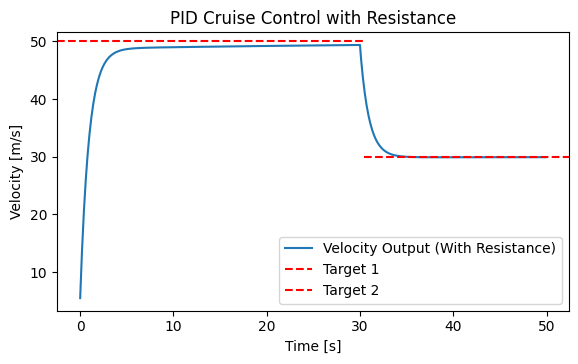

#### Result for Kp = 1.0, Ki = 0.075 & Kd = 0.01 (see the influence of Ki) part. 2/2

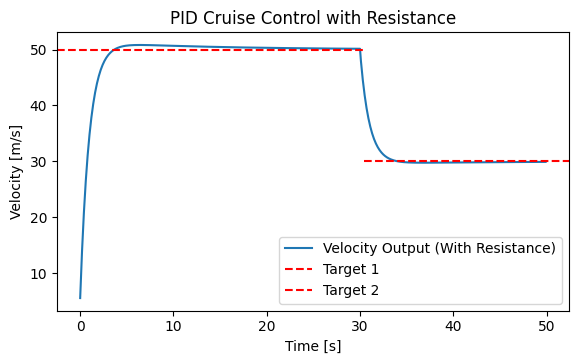

#### Result for Kp = 1.0, Ki = 0.05 & Kd = 0.005 (see the influence of Kd) part. 1/2

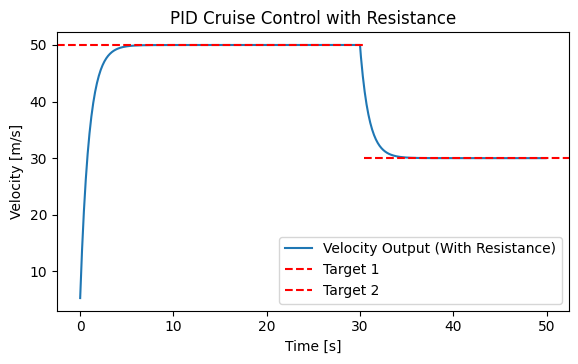

#### Result for Kp = 1.0, Ki = 0.05 & Kd = 0.02 (see the influence of Kd) part. 2/2

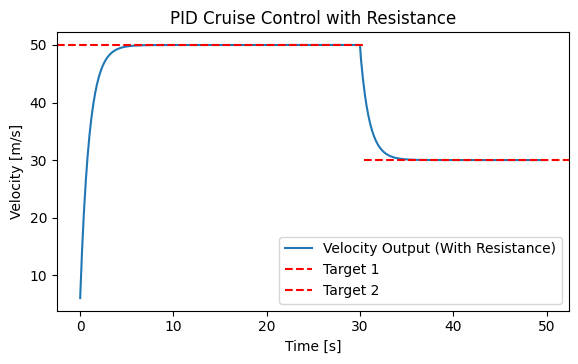

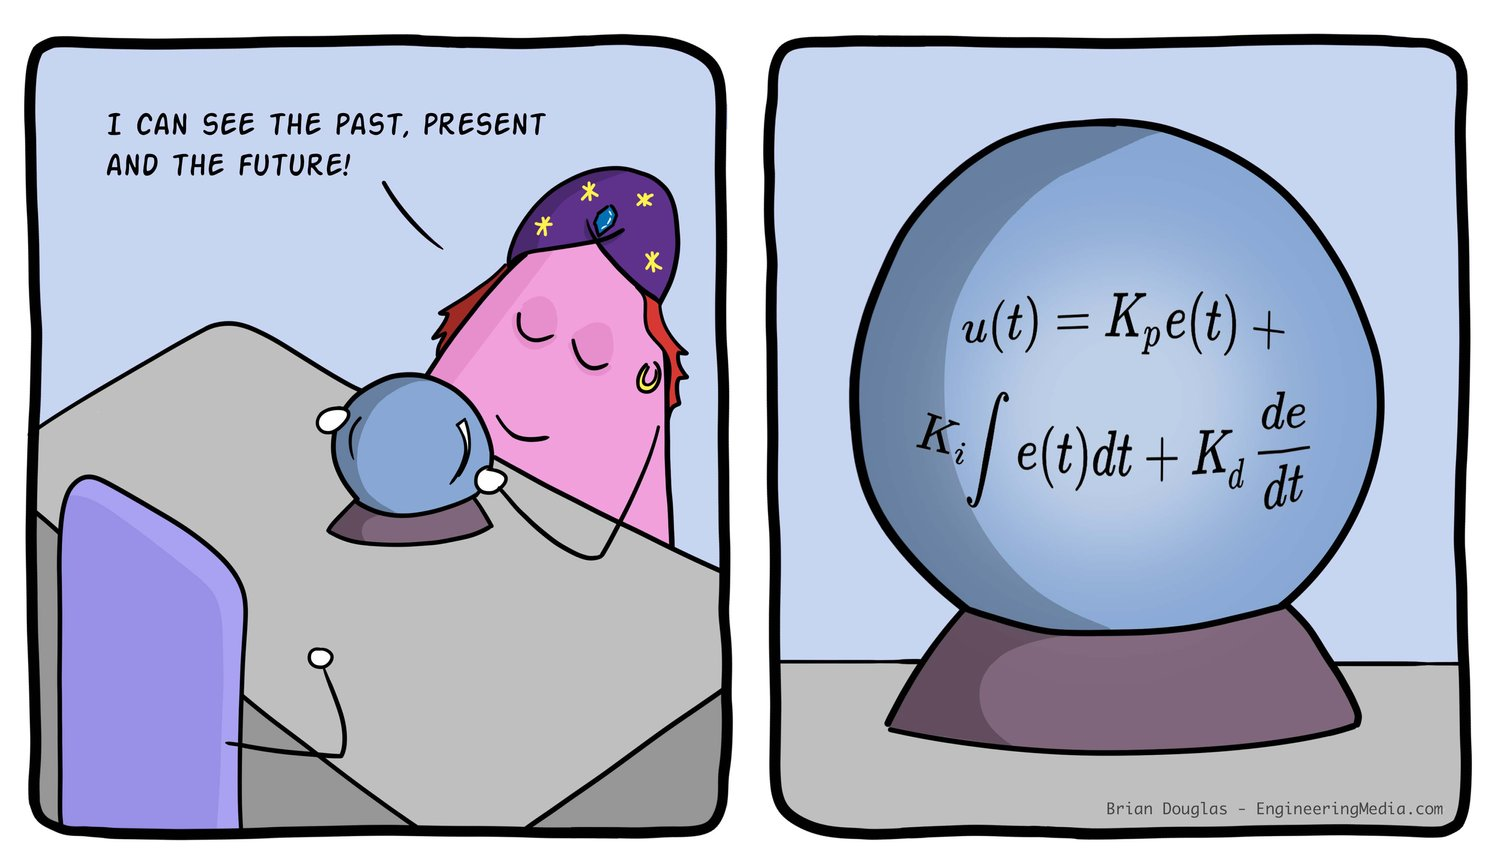

You have now successfully built a longitudinal PID controll! Now, we will add a lateral PID controll as well in order to control the direction of our vehicle.
For this part, we will move to the "control.py" file to finalize the PID controller. 

When you are done with your control.py file, you can test it by running the Simulation_Control.py script to see your car drive around the CARLA simulation.